In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from motion_models import MM_CTRV
from filters import EKF_CTRV, UKF_CTRV, filter_cyclic
from simulation import *
from scenarios import get_scenario
from scipy.stats import circmean

In [2]:
# experiment parameters
T = 0.05
sc_id = '5'
SEED = 1
std_r = 0.5
std_phi = np.radians(2)
sim_var_v, sim_var_w = 2**2, 0

# generating ground truth
sc = get_scenario(sc_id, T)
n_frames = int(sc['n_frames'])
m_ctrv = MM_CTRV(sim_var_v, sim_var_w)
sim_state = simulate_motion_CTRV(T, n_frames, sc['x_init'], m_ctrv, sc['accw_frames'])

In [5]:
# How robust are they to mismatches in process noise?

frame_vec = np.arange(n_frames)
np.random.seed(SEED)
KF = EKF_CTRV
n_iter = 10
varv_vec = np.array([1, 3, 5, 10])**2
varw_vec = np.radians([5, 10, 15, 30, 50])**2

n_varv = len(varv_vec)
n_varw = len(varw_vec)
Err = np.zeros((5, n_varv, n_varw, n_frames, n_iter))

exp_count = 1
for iter_ in range(n_iter):
    print(f'iter {iter_+1}/{n_iter}')
    meas_pol = simulate_measurements_polar(sim_state, std_r, std_phi, 0.1)
    for i, var_v in enumerate(varv_vec):
        for j, var_w in enumerate(varw_vec):
            kf = KF(T, var_v, var_w, std_r, std_phi)

            Err_iter = np.zeros((5, n_frames))
            
            for frame in frame_vec:
                meas = np.array([meas_pol[IMR, frame], meas_pol[IMPHI, frame]])
                filter_cyclic(frame, kf, meas)
                Err_iter[:, frame] = kf.x - sim_state[:, frame]
                    
            Err_iter[IPHI, :] = wrap_angle2(Err_iter[IPHI, :])
            Err[:, i, j, :, iter_] = Err_iter
        exp_count += 1

# computing RMSE
Err = np.reshape(Err, newshape=(5, n_varv, n_varw, -1))
rmse_pos = np.sqrt(np.mean(Err[IX]**2 + Err[IY]**2, axis=-1))
rmse_vel = np.sqrt(np.mean(Err[IV]**2, axis=-1))
rmse_phi = np.degrees(np.sqrt(circmean(Err[IPHI]**2, axis=-1)))
rmse_w = np.degrees(np.sqrt(np.mean(Err[IW]**2, axis=-1)))

# saving resutls from experiment
data = {
    'varvs': varv_vec,
    'varws': varw_vec,
    'rmse_pos': rmse_pos,
    'rmse_phi': rmse_phi,
    'rmse_vel': rmse_vel,
    'rmse_w': rmse_w,
}
np.savez(f"{KF.__name__}_evaluation", **data)

iter 1/10
iter 2/10
iter 3/10
iter 4/10
iter 5/10
iter 6/10
iter 7/10
iter 8/10
iter 9/10
iter 10/10


C:\Users\truji\AppData\Local\Temp\ipykernel_24788\3127211343.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0, 0.82, 1))
C:\Users\truji\AppData\Local\Temp\ipykernel_24788\3127211343.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0, 0.82, 1))
C:\Users\truji\AppData\Local\Temp\ipykernel_24788\3127211343.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0, 0, 0.82, 1))


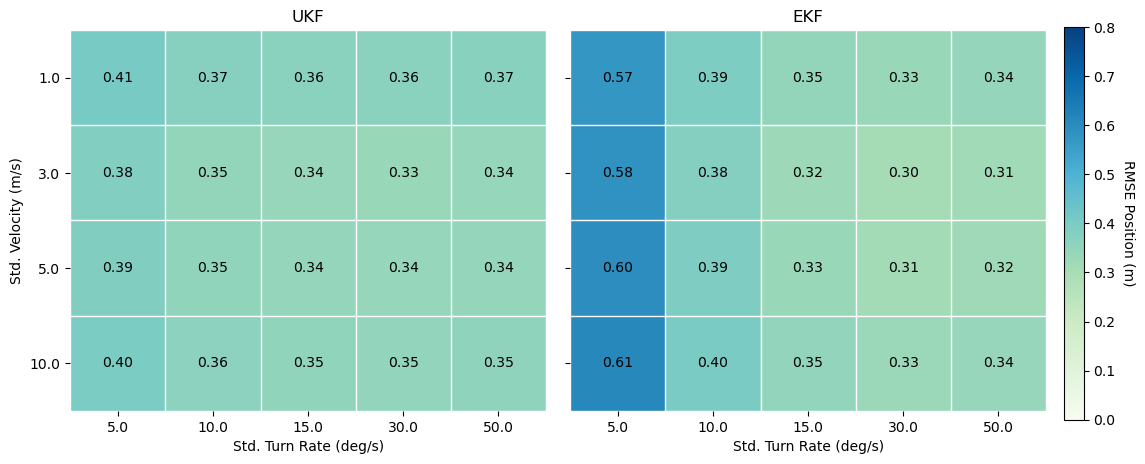

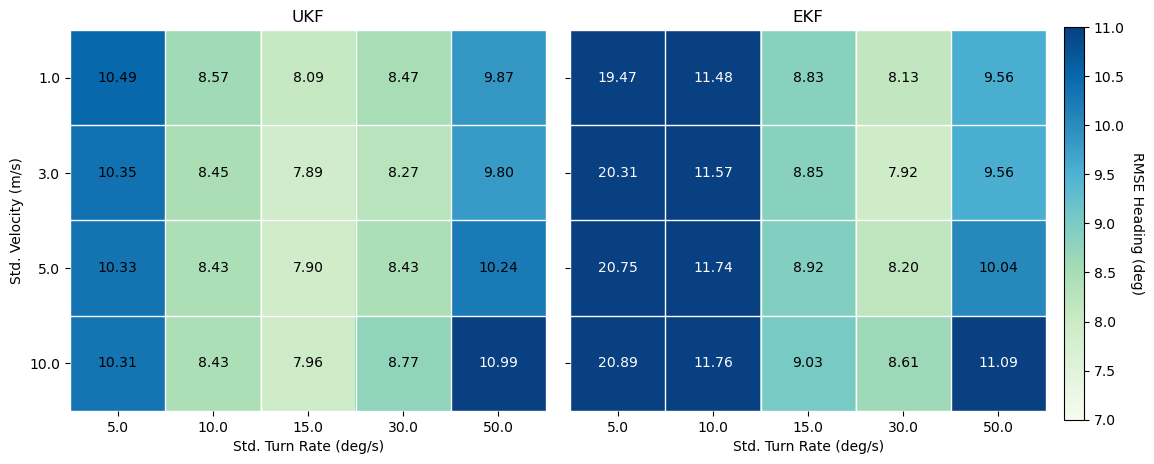

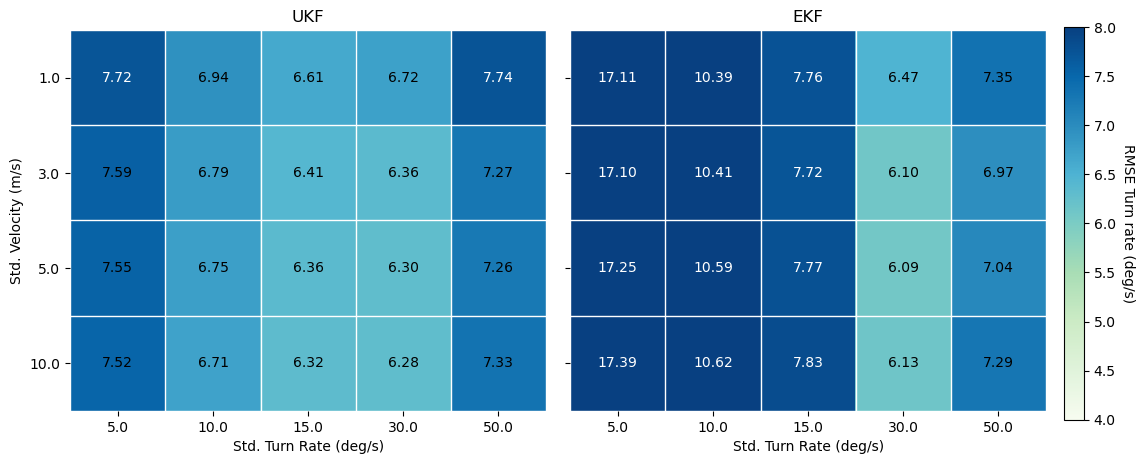

In [7]:
from utils import *

data_ukf = np.load('UKF_CTRV_evaluation.npz')
data_ekf = np.load('EKF_CTRV_evaluation.npz')

stdvs = np.round(np.sqrt(data_ukf['varvs']), 2)
stdws = np.round(np.degrees(np.sqrt(data_ukf['varws'])), 2)

plot_options = [
    {'data_label': 'rmse_pos', 'cbar_label': "RMSE Position (m)", 'limits': (0, 0.8)},
    # {'data_label': 'rmse_vel', 'cbar_label': "RMSE Veloctiy (m/s)", 'limits': (0.5, 2)},
    {'data_label': 'rmse_phi', 'cbar_label': "RMSE Heading (deg)", 'limits': (7, 11)},
    {'data_label': 'rmse_w', 'cbar_label': "RMSE Turn rate (deg/s)", 'limits': (4, 8)}
]
exp_options = [
    {'name': 'UKF', 'data': data_ukf},
    {'name': 'EKF', 'data': data_ekf},
]

for p in plot_options:
    fig, axes = plt.subplots(figsize=(13, 6), ncols=2, sharey=True)
    label = p['data_label']
    vmin, vmax = p['limits'][0], p['limits'][1]
    thr = 0.9*(vmax-vmin) + vmin
    for i, exp in enumerate(exp_options):
        # ax = fig.add_subplot(gs[0, i])
        ax = axes[i]
        ax.set_title(exp['name'])
        im = heatmap(exp['data'][label], stdvs, stdws, ax=ax,
                        cmap="GnBu", cbarlabel=p['cbar_label'], vmin=vmin, vmax=vmax)
        texts = annotate_heatmap(im, valfmt="{x:.2f}", threshold=thr)
        if i == 0:
            ax.set_ylabel('Std. Velocity (m/s)')
        ax.set_xlabel('Std. Turn Rate (deg/s)')
    cbar = fig.colorbar(im, ax=axes, fraction=.1, pad=0, shrink=0.85)
    cbar.ax.set_ylabel(p['cbar_label'], rotation=-90, va="bottom")
    fig.tight_layout(rect=(0, 0, 0.82, 1))
plt.show()